In [2]:
import pandas as pd

# Load the dataset
file_path = 'hotel_bookings.csv'
data = pd.read_csv(file_path)

# Display basic info
print("Initial Data Overview:")
print(data.info())
print("\nMissing Values Count:")
print(data.isnull().sum())

# --- Data Cleaning ---
# 1. Handle missing values
# Replace missing numerical values with median and categorical with mode
for col in data.columns:
    if data[col].dtype == 'object':  # Categorical
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:  # Numerical
        data[col].fillna(data[col].median(), inplace=True)

# 2. Fix format inconsistencies
# Example: Convert dates to datetime format
date_cols = ['reservation_status_date', 'arrival_date_year']
if 'reservation_status_date' in data.columns:
    data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'], errors='coerce')


Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64 

In [8]:
output_path = 'cleaned_hotel_bookings.csv'
data.to_csv(output_path, index=False)


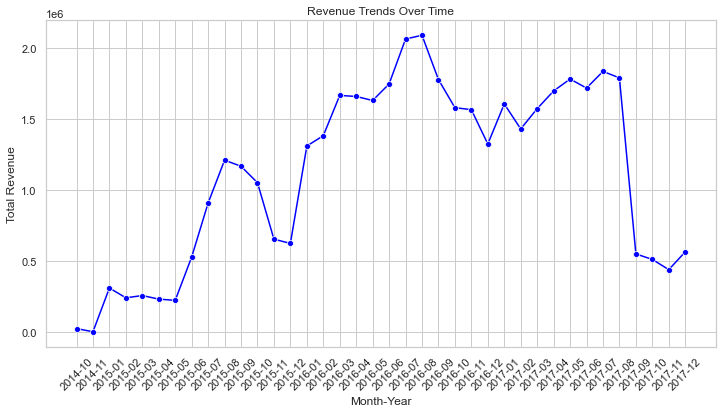

Cancellation Rate: 37.04%


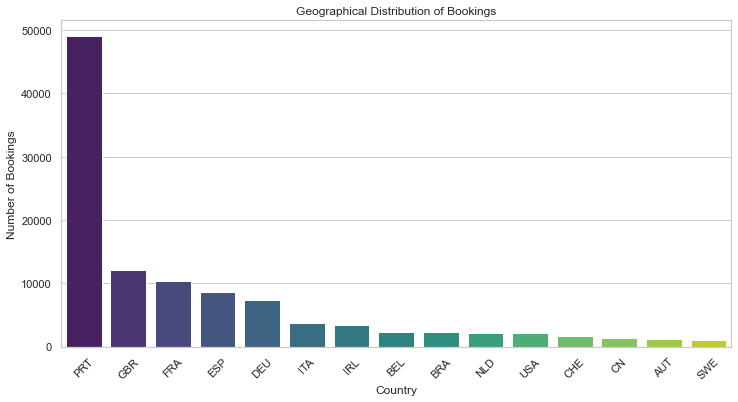

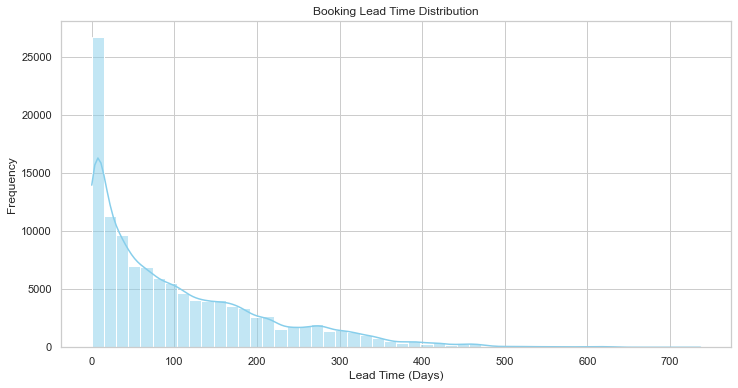

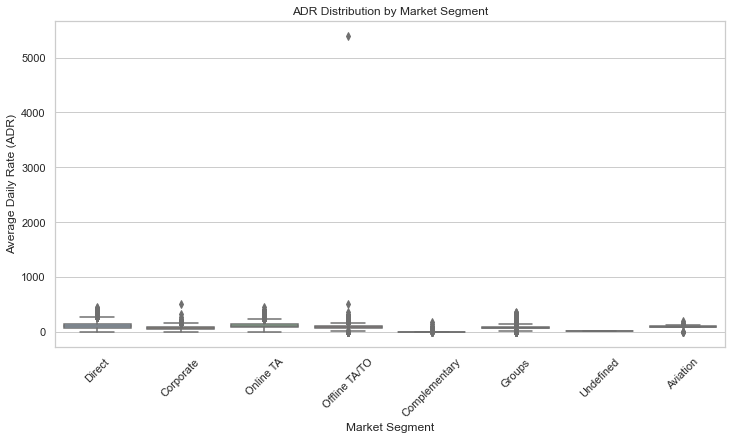

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
file_path = 'cleaned_hotel_bookings.csv'
data = pd.read_csv(file_path)

# Set plot style
sns.set(style="whitegrid")

# --- 1. Revenue Trends Over Time ---
# Create revenue column
data['revenue'] = (data['stays_in_weekend_nights'] + data['stays_in_week_nights']) * data['adr']

# Group by month-year
data['month_year'] = pd.to_datetime(data['reservation_status_date']).dt.to_period('M').astype(str)  # Convert to str
revenue_trends = data.groupby('month_year')['revenue'].sum().reset_index()

# Plot revenue trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_year', y='revenue', data=revenue_trends, marker='o', color='blue')
plt.title('Revenue Trends Over Time')
plt.xticks(rotation=45)
plt.ylabel('Total Revenue')
plt.xlabel('Month-Year')
plt.show()

# --- 2. Cancellation Rate ---
canceled = len(data[data['is_canceled'] == 1])
total_bookings = len(data)
cancellation_rate = (canceled / total_bookings) * 100

print(f"Cancellation Rate: {cancellation_rate:.2f}%")

# --- 3. Geographical Distribution ---
plt.figure(figsize=(12, 6))
country_counts = data['country'].value_counts().head(15)  # Top 15 countries
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title('Geographical Distribution of Bookings')
plt.ylabel('Number of Bookings')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()

# --- 4. Booking Lead Time Distribution ---
plt.figure(figsize=(12, 6))
sns.histplot(data['lead_time'], bins=50, color='skyblue', kde=True)
plt.title('Booking Lead Time Distribution')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Frequency')
plt.show()

# --- 5. Additional Analytics: ADR Distribution by Market Segment ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='market_segment', y='adr', data=data, palette='pastel')
plt.title('ADR Distribution by Market Segment')
plt.xticks(rotation=45)
plt.ylabel('Average Daily Rate (ADR)')
plt.xlabel('Market Segment')
plt.show()


In [12]:
pip install pandas faiss-cpu sentence-transformers transformers torch


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Using cached faiss_cpu-1.10.0-cp39-cp39-win_amd64.whl (13.7 MB)
  Using cached sentence_transformers-3.4.1-py3-none-any.whl (275 kB)


In [13]:
import pandas as pd
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# --- 1. Load the Cleaned Data ---
file_path = 'cleaned_hotel_bookings.csv'
data = pd.read_csv(file_path)

# --- 2. Create Natural Language Representations of Booking Data ---
def convert_to_text(row):
    """Convert a row of booking data into readable text format"""
    text = (
        f"Booking made from {row['country']} on {row['reservation_status_date']}. "
        f"Stayed for {row['stays_in_weekend_nights']} weekend nights and {row['stays_in_week_nights']} weekday nights. "
        f"Lead time: {row['lead_time']} days. "
        f"Market Segment: {row['market_segment']}. "
        f"ADR: {row['adr']}. "
        f"Booking status: {'Cancelled' if row['is_canceled'] == 1 else 'Confirmed'}."
    )
    return text

# Convert entire dataset to text
data['text'] = data.apply(convert_to_text, axis=1)

# --- 3. Create Embeddings ---
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(data['text'].tolist(), convert_to_tensor=False)

# --- 4. Store Embeddings in FAISS ---
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance index
index.add(np.array(embeddings))

# --- 5. Define the RAG Q&A Function ---
def retrieve_answer(question, top_k=5):
    """Retrieve relevant booking data using FAISS and generate an answer with LLM"""
    
    # Generate question embedding
    question_embedding = model.encode([question], convert_to_tensor=False)
    
    # Search in FAISS index
    distances, indices = index.search(np.array(question_embedding), top_k)
    
    # Retrieve relevant rows
    relevant_texts = [data['text'][i] for i in indices[0]]
    
    # Prepare context for the LLM
    context = "\n".join(relevant_texts)
    
    # Use LLM to answer the question
    llm = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")
    prompt = f"Context:\n{context}\n\nQuestion: {question}\nAnswer:"
    result = llm(prompt, max_length=300, do_sample=True, temperature=0.7)[0]['generated_text']
    
    return result

# --- 6. Example Queries ---
print("\nExample Queries:")
queries = [
    "Show me total revenue for July 2017.",
    "Which locations had the highest booking cancellations?",
    "What is the average price of a hotel booking?"
]

for query in queries:
    print(f"\nQuestion: {query}")
    answer = retrieve_answer(query)
    print(f"Answer: {answer}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Example Queries:

Question: Show me total revenue for July 2017.


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer: Context:
Booking made from PER on 2017-06-19. Stayed for 1 weekend nights and 0 weekday nights. Lead time: 1 days. Market Segment: Direct. ADR: 150.0. Booking status: Confirmed.
Booking made from PER on 2017-06-19. Stayed for 1 weekend nights and 0 weekday nights. Lead time: 1 days. Market Segment: Direct. ADR: 150.0. Booking status: Confirmed.
Booking made from PER on 2017-12-03. Stayed for 0 weekend nights and 2 weekday nights. Lead time: 2 days. Market Segment: Direct. ADR: 243.0. Booking status: Confirmed.
Booking made from PER on 2016-05-24. Stayed for 2 weekend nights and 5 weekday nights. Lead time: 1 days. Market Segment: Online TA. ADR: 148.04. Booking status: Cancelled.
Booking made from PER on 2017-06-03. Stayed for 0 weekend nights and 2 weekday nights. Lead time: 11 days. Market Segment: Direct. ADR: 123.0. Booking status: Cancelled.

Question: Show me total revenue for July 2017.
Answer:

Question: I have a booking made from PER on 2017-06-19. Stayed for 3 nights,

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer: Context:
Booking made from USA on 2017-04-27. Stayed for 1 weekend nights and 0 weekday nights. Lead time: 64 days. Market Segment: Direct. ADR: 265.0. Booking status: Cancelled.
Booking made from USA on 2017-04-04. Stayed for 2 weekend nights and 5 weekday nights. Lead time: 77 days. Market Segment: Direct. ADR: 311.0. Booking status: Cancelled.
Booking made from USA on 2017-04-08. Stayed for 2 weekend nights and 3 weekday nights. Lead time: 76 days. Market Segment: Direct. ADR: 265.0. Booking status: Cancelled.
Booking made from USA on 2016-01-09. Stayed for 2 weekend nights and 6 weekday nights. Lead time: 74 days. Market Segment: Direct. ADR: 155.5. Booking status: Cancelled.
Booking made from USA on 2017-03-23. Stayed for 0 weekend nights and 1 weekday nights. Lead time: 316 days. Market Segment: Direct. ADR: 93.5. Booking status: Cancelled.

Question: Which locations had the highest booking cancellations?
Answer:
Booking made from USA on 2017-03-30. Stayed for 1 weekend n

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer: Context:
Booking made from USA on 2017-10-01. Stayed for 1 weekend nights and 0 weekday nights. Lead time: 0 days. Market Segment: Online TA. ADR: 30.99. Booking status: Confirmed.
Booking made from USA on 2015-11-10. Stayed for 0 weekend nights and 4 weekday nights. Lead time: 0 days. Market Segment: Online TA. ADR: 159.75. Booking status: Confirmed.
Booking made from USA on 2015-11-14. Stayed for 0 weekend nights and 1 weekday nights. Lead time: 109 days. Market Segment: Direct. ADR: 74.8. Booking status: Confirmed.
Booking made from USA on 2016-05-20. Stayed for 1 weekend nights and 3 weekday nights. Lead time: 5 days. Market Segment: Corporate. ADR: 98.32. Booking status: Confirmed.
Booking made from USA on 2017-06-25. Stayed for 0 weekend nights and 1 weekday nights. Lead time: 149 days. Market Segment: Corporate. ADR: 154.0. Booking status: Confirmed.

Question: What is the average price of a hotel booking?
Answer:

We take a look at the average price of a hotel booking. 

In [14]:
import pandas as pd
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# --- 1. Load the Cleaned Data ---
file_path = 'cleaned_hotel_bookings.csv'
data = pd.read_csv(file_path)

# --- 2. Create Natural Language Representations of Booking Data ---
def convert_to_text(row):
    """Convert a row of booking data into readable text format"""
    text = (
        f"Booking made from {row['country']} on {row['reservation_status_date']}. "
        f"Stayed for {row['stays_in_weekend_nights']} weekend nights and {row['stays_in_week_nights']} weekday nights. "
        f"Lead time: {row['lead_time']} days. "
        f"Market Segment: {row['market_segment']}. "
        f"ADR: {row['adr']}. "
        f"Booking status: {'Cancelled' if row['is_canceled'] == 1 else 'Confirmed'}."
    )
    return text

# Convert entire dataset to text
data['text'] = data.apply(convert_to_text, axis=1)

# --- 3. Create Embeddings ---
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(data['text'].tolist(), convert_to_tensor=False)

# --- 4. Store Embeddings in FAISS ---
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# --- 5. Define the RAG Q&A Function ---
def retrieve_answer(question, top_k=5):
    """Retrieve relevant booking data using FAISS and generate an answer with LLM"""
    
    # Generate question embedding
    question_embedding = model.encode([question], convert_to_tensor=False)
    
    # Search in FAISS index
    distances, indices = index.search(np.array(question_embedding), top_k)
    
    # Retrieve relevant rows
    relevant_texts = [data['text'][i] for i in indices[0]]
    
    # Prepare context for the LLM
    context = "\n".join(relevant_texts)

    # Use LLM to answer the question
    llm = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")

    # Apply truncation and pad token ID fixes
    prompt = f"Context:\n{context}\n\nQuestion: {question}\nAnswer:"
    result = llm(
        prompt, 
        max_length=300, 
        do_sample=True, 
        temperature=0.7, 
        truncation=True,                # ✅ Enable truncation
        pad_token_id=50256              # ✅ Specify pad_token_id explicitly
    )[0]['generated_text']
    
    return result

# --- 6. Example Queries ---
print("\nExample Queries:")
queries = [
    "Show me total revenue for July 2017.",
    "Which locations had the highest booking cancellations?",
    "What is the average price of a hotel booking?"
]

for query in queries:
    print(f"\nQuestion: {query}")
    answer = retrieve_answer(query)
    print(f"Answer: {answer}")



Example Queries:

Question: Show me total revenue for July 2017.
Answer: Context:
Booking made from PER on 2017-06-19. Stayed for 1 weekend nights and 0 weekday nights. Lead time: 1 days. Market Segment: Direct. ADR: 150.0. Booking status: Confirmed.
Booking made from PER on 2017-06-19. Stayed for 1 weekend nights and 0 weekday nights. Lead time: 1 days. Market Segment: Direct. ADR: 150.0. Booking status: Confirmed.
Booking made from PER on 2017-12-03. Stayed for 0 weekend nights and 2 weekday nights. Lead time: 2 days. Market Segment: Direct. ADR: 243.0. Booking status: Confirmed.
Booking made from PER on 2016-05-24. Stayed for 2 weekend nights and 5 weekday nights. Lead time: 1 days. Market Segment: Online TA. ADR: 148.04. Booking status: Cancelled.
Booking made from PER on 2017-06-03. Stayed for 0 weekend nights and 2 weekday nights. Lead time: 11 days. Market Segment: Direct. ADR: 123.0. Booking status: Cancelled.

Question: Show me total revenue for July 2017.
Answer:
Booking mad